In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MyColab/ISSMPM')
!ls

Mounted at /content/drive
 dataset
 DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx
 FaceDetection_CNN_classification.ipynb
 FaceDetection_CNN_Regression_2022_04_01_06_24_08.ipynb
 FaceDetection_CNN_Regression_2022_04_01_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_04_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_05_12.ipynb
 FaceDetection_CNN_Regression_TransferLearning.ipynb
 FaceDetection_CNN_Regression_TransferLearning_withVideoDataframe.ipynb
 FaceDetection_haar.ipynb
 FaceDetection.ipynb
 faceexp-comparison-data-test-public.csv
 PainRecognition_CNN_Regression.ipynb
 PainRecognition_TransferLearning.ipynb
 training
'Video Processing2.ipynb'
'Video Processing.ipynb'


In [2]:
#installation of mediapipe library
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 413 kB/s 


In [3]:
#import require library
import cv2
import os
import numpy as np
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Activation
from tensorflow.keras import optimizers,regularizers
import sklearn
import datetime as dt

import tensorflow as tf
from google.colab.patches import cv2_imshow
import mediapipe as mp

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.8.0
numpy:       1.21.6
matplotlib:  3.2.2
sklearn:     1.0.2


In [4]:
"""
import Delaware pain database which provided a set of painful expressions and corresponding norming data

Refer to the link: https://psyarxiv.com/kjez5/
Target: naming convention described in read-me file.

Expression_Highest: Categorical variable representing the highest average emotion rating (e.g., from "Fear_Expression" to "Pain_Expression"); for example, if a given expression had an average "Anger_Expression" rating of 4.00, and all other ratings from "Fear_Expression" to "Pain_Expression" were 2.00, that stimulis would have a value of "anger" for "Expression_Highest"

Pain_Expression: Average rating of pain for a given expression made by a particular target; 1 ("not at all") to 7 ("extremely") scale, in response to "How much does this face look like it's in pain?"

The CNN model will be trained to predict the pain expression of the face in the self-recorded video.
"""

usecols=['Target','Expession_Highest','Pain_Expression']
colType=['string','string','string']
dtypeDF = dict(zip(usecols,colType))
normingData = pd.read_excel('DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx','DPD_NormingData',dtype=dtypeDF,usecols=usecols)
normingData.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Target,Pain_Expression,Expession_Highest
0,DPD_1_WM34_p5c,5.9555556,pain
1,DPD_1_WM39_p5c,5.82,pain
2,DPD_1_OF8_p4c,2.0487805,sad
3,DPD_1_AF12_p4c,2.2857143,surprised
4,DPD_1_AF12_p6c,2.6428571,sad


In [5]:
#filter out no facial expression
painNormingData = normingData[normingData['Expession_Highest']=='pain']
nonePainNormingData = normingData[(normingData['Expession_Highest']!='.') & (normingData['Expession_Highest']!='pain')][:272]
normingData = pd.concat([painNormingData,nonePainNormingData]).sort_index()

In [6]:
#Convert pain expression to float
def is_number_tryexcept(s):
    """ Returns True is string is a number. """
    try:
        float(s)
        return True
    except ValueError:
        return False
filterNormingData = normingData[normingData['Pain_Expression'].apply(is_number_tryexcept)].astype({'Pain_Expression':'float'})
filterNormingData['Pain_Expression'].describe()

count    544.000000
mean       3.350831
std        1.094587
min        1.150000
25%        2.424689
50%        3.339394
75%        4.195255
max        5.955556
Name: Pain_Expression, dtype: float64

In [7]:
#Define variable to store image list
image_file_list = sorted(os.listdir('dataset'))
dfImageList = filterNormingData[(filterNormingData['Target']+'.JPG').isin(image_file_list)]
Pain_Expression = dfImageList['Pain_Expression']
expression_image_list = list(dfImageList['Target']+'.JPG')
del normingData,filterNormingData, dfImageList,painNormingData,nonePainNormingData,image_file_list

In [8]:
#Use Medipipe Face Detection Pretained Model to execute Face Detection and crop out the face from the image list
mp_face_detection = mp.solutions.face_detection
image_Morethan1Detection = []
no_face_image = []
preproc_img = []

#Loop all the file defined in the image list
for imageName in expression_image_list:
  img = cv2.imread(f'dataset/{imageName}')
  
  with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:

    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    #Skip if there is no face detected.
    if not results.detections:
      no_face_image.append(imageName)
      continue
    #Skip if there are multiple faces detected.
    if len(results.detections)>1:
      image_Morethan1Detection.append(imageName)
      continue
    
    #Retrieve the coordination of the face from the result of detection
    row, column,channel = img.shape
    y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
    h = int(results.detections[0].location_data.relative_bounding_box.height*row)
    x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
    w = int(results.detections[0].location_data.relative_bounding_box.width*column)
    face = img[y:y + h, x:x + w]

    #Resize all the images to 100x100 and convert them to grayscale as the pain expression should be color invariant
    resized = cv2.resize(face, (100, 100))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    preproc_img.append((imageName,gray))

#All the images can be detected with only one face
print(len(image_Morethan1Detection))
print(len(no_face_image))
print(len(preproc_img))

0
0
434


In [9]:
#Perform image preprocessing to flip the image horizontally and expand the training data
flip_preproc_img = [(f'flip_{imageName}',cv2.flip(data,1)) for imageName, data in preproc_img]
main_image_list = preproc_img + flip_preproc_img
main_image_regression = list(Pain_Expression) + list(Pain_Expression)
print(len(main_image_list))
print(len(main_image_regression))

868
868


[4.1555556]


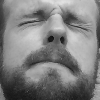

In [10]:
#Perform train test split and display any image from the training dataset
from sklearn.model_selection import train_test_split
y_reg = np.array(main_image_regression).reshape(-1,1)
X = np.array([ data for  imageName, data in main_image_list]).reshape(-1,100,100,1)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.1, random_state=42)

randomNumber = random.randint(0, len(X_train)-1)
Demo = X_train[randomNumber]
print(y_reg[randomNumber])
cv2_imshow(Demo)

In [11]:
#Define the CNN regression model
init_lr = 1e-4
epochs = 400
opt = optimizers.Adam(lr=init_lr, decay=init_lr / epochs)
modelname   = 'PainRecognition'

def createModel():
    inp = Input(shape=(100,100,1))

    x = Conv2D(16,(3,3),padding='same',name='conv2d_1')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(16,(3,3),padding='same',name='conv2d_2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64,(3,3),padding='same',name='conv2d_3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,(3,3),padding='same',name='conv2d_4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,(3,3),padding='same',name='conv2d_5')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256,(3,3),padding='same',name='conv2d_6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(1024,(3,3),padding='same',name='conv2d_7')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(1024,(3,3),padding='same',name='conv2d_8')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten(name='flatten_reg')(x)
    x = Dense(128,activation='relu',name='dense128_reg')(x)
    x = Dropout(0.5)(x)
    x = Dense(16,activation='relu',name='dense10_reg')(x)
    x = Dropout(0.25)(x)
    output = Dense(1,activation='linear',name='reg')(x)
    
    model = Model(inputs=inp,outputs=output) 
    model.compile(loss='mse',
                   optimizer=opt,
                  metrics=['MeanSquaredError'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 activation_1 (Activation)   (None, 100, 100, 16)      0         
                                                             

In [12]:
#Define the callback list and the csv file to store the training records
currenttime     = str(dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
folderpath      = '/content/drive/MyDrive/MyColab/ISSMPM/training/'
filepath        = f'{folderpath}{modelname}_CNNRegression_400.hdf5'
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_loss', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')
csvfilename     = f'{folderpath}{modelname}_CNNRegression_400.csv'
csv_logger      = CSVLogger(csvfilename)
callbacks_list  = [checkpoint,csv_logger]

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition_CNNRegression_400.hdf5
Path to log:   /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition.csv


In [ ]:
model.fit(X_train, 
          y_reg_train, 
          validation_data=(X_test, y_reg_test), 
          epochs=epochs, 
          batch_size=24,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/400
33/33 [==============================] - 4s 97ms/step - loss: 10.8287 - mean_squared_error: 10.8287 - val_loss: 11.7484 - val_mean_squared_error: 11.7484
Epoch 2/400
33/33 [==============================] - 3s 89ms/step - loss: 4.7469 - mean_squared_error: 4.7469 - val_loss: 10.8599 - val_mean_squared_error: 10.8599
Epoch 3/400
33/33 [==============================] - 3s 87ms/step - loss: 4.4616 - mean_squared_error: 4.4616 - val_loss: 9.7210 - val_mean_squared_error: 9.7210
Epoch 4/400
33/33 [==============================] - 3s 86ms/step - loss: 4.2864 - mean_squared_error: 4.2864 - val_loss: 8.6676 - val_mean_squared_error: 8.6676
Epoch 5/400
33/33 [==============================] - 3s 92ms/step - loss: 4.0131 - mean_squared_error: 4.0131 - val_loss: 6.8543 - val_mean_squared_error: 6.8543
Epoch 6/400
33/33 [==============================] - 3s 89ms/step - loss: 3.7887 - mean_squared_error: 3.7887 - val_loss: 5.8404 - val_mean_squared_error: 5.8404
Epoch 7/400
33/33 [===

In [13]:
#Load the weights of the model
modelGo.load_weights(filepath)
print("Model weights loaded from:", filepath)

modelGo.compile(loss='mse',
                   optimizer=opt,
                  metrics=['MeanSquaredError'])

predicts_reg    = modelGo.predict(X_test)
print("Prediction completes.")

Model weights loaded from: /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition_CNNRegression_400.hdf5
Prediction completes.


### Pain Expression

The mean squared error (MSE) on test set:0.3863119978648445


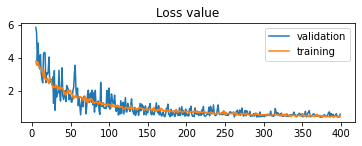

In [16]:
#Plot the training records to observe any overfitting on the model.
testScores  = sklearn.metrics.mean_squared_error(y_reg_test,predicts_reg)

print(f"The mean squared error (MSE) on test set:{testScores}")

records     = pd.read_csv(csvfilename)
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'][5:], label="validation")
plt.plot(records['loss'][5:],label="training")
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.legend()
plt.show()

In [ ]:
del X_train, X_test, y_reg_train, y_reg_test, X, y_reg,flip_preproc_img,main_image_list,main_image_regression,preproc_img

In [ ]:
#Perform predictions on the withSpec_pain_correctpose video which is recorded to conduct correct pose with simulated pain face.
#We would like to use the CNN Regression model to predict the pain expression.
filename = 'withSpec_pain_correctpose'

cap = cv2.VideoCapture(f'dataset/Video/{filename}.mp4')
withSpec_pain_correctpose = []
while True:
  ret, frame = cap.read()
  if ret:
    img = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.detections:
          continue
        if len(results.detections)>1:
          continue
        row, column,channel = img.shape
        y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
        h = int(results.detections[0].location_data.relative_bounding_box.height*row)
        x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
        w = int(results.detections[0].location_data.relative_bounding_box.width*column)
        face = img[y:y + h, x:x + w]

        #According to the observation on the video, we understood that the resolution of the face after cropped from the video frame is not large(around 100x100 pixels)
        #This is the reason that the training dataset will be reshaped to 100x100 and feed into a model with input layer (100,100,1)
        resized = cv2.resize(face, (100, 100))
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        currentFrame_predicts    = modelGo.predict(gray.reshape(-1,100,100,1))
        withSpec_pain_correctpose.append((face,currentFrame_predicts[0]))
  else:
    cap.release()
    break

Text(0.5, 1.0, 'Pain Intensity with pain face')

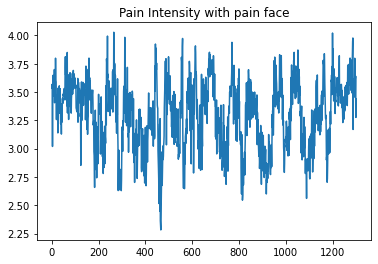

In [ ]:
#plot the predicted pain expression for the withSpec_pain_correctpose
plt.figure()
plt.plot([value[1] for value in withSpec_pain_correctpose], label="reg_pain")
plt.title('Pain Intensity with pain face',fontsize=12)

In [ ]:
#Download the prediction on the withSpec_pain_correctpose video 
#The test score will be used to increase the pain expression of all the single face detected on the frames because we consider all the frames on withSpec_pain_correctpose has high pain expression on face.
#Test score is the overall mean square error for testing dataset. Thus, we will add the square root of the error to all predicted pain expression on the frames
import math
import pickle

with open(f'/content/drive/MyDrive/MyColab/ISSMPM/training/{filename}_CNNRegression.pkl','wb') as f:
  pickle.dump({'mean':testScores,'data':withSpec_pain_correctpose},f)
del withSpec_pain_correctpose

In [ ]:
#Perform predictions on the withSpec_nopain_incorrectpose video which is recorded to conduct correct pose with simulated no pain face.
#We would like to use the CNN Regression model to predict the pain expression.
filename = 'withSpec_nopain_incorrectpose'

cap = cv2.VideoCapture(f'dataset/Video/{filename}.mp4')
withSpec_nopain_incorrectpose = []
while True:
  ret, frame = cap.read()
  if ret:
    img = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.detections:
          continue
        if len(results.detections)>1:
          continue
        row, column,channel = img.shape
        y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
        h = int(results.detections[0].location_data.relative_bounding_box.height*row)
        x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
        w = int(results.detections[0].location_data.relative_bounding_box.width*column)
        face = img[y:y + h, x:x + w]

        #According to the observation on the video, we understood that the resolution of the face after cropped from the video frame is not large(around 100x100 pixels)
        #This is the reason that the training dataset will be reshaped to 100x100 and feed into a model with input layer (100,100,1)
        resized = cv2.resize(face, (100, 100))
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        currentFrame_predicts    = modelGo.predict(gray.reshape(-1,100,100,1))
        withSpec_nopain_incorrectpose.append((face,currentFrame_predicts[0]))
  else:
    cap.release()
    break

Text(0.5, 1.0, 'Pain Intensity with no pain face')

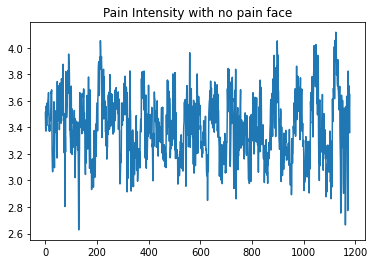

In [ ]:
#plot the predicted pain expression for the withSpec_nopain_incorrectpose
plt.figure()
plt.plot([value[1] for value in withSpec_nopain_incorrectpose], label="reg_nopain")
plt.title('Pain Intensity with no pain face',fontsize=12)

In [ ]:
#Download the prediction on the withSpec_nopain_incorrectpose video 
#The test score will be used to decrease the pain expression of all the single face detected on the frames because we consider all the frames on withSpec_pain_correctpose has low pain expression on face.
#Test score is the overall mean square error for testing dataset. Thus, we will deduct the square root of the error to all predicted pain expression on the frames
import math
import pickle

with open(f'/content/drive/MyDrive/MyColab/ISSMPM/training/{filename}_CNNRegression.pkl','wb') as f:
  pickle.dump({'mean':testScores,'data':withSpec_nopain_incorrectpose},f)
del withSpec_nopain_incorrectpose